In [1]:
%load_ext autoreload
%autoreload 2

import os, sys
from pathlib import Path

from matplotlib import pyplot as plt
# from tqdm import tqdm
from tqdm.notebook import tqdm
from pathlib import Path

### Load a classifier

In [2]:
SPLATS = {
    'rats': {
        'base_dir': '/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features',
        'load_config': "2025-07-25_074037/config.yml",
    },
    'birds': {
        'base_dir': '/workspace/fieldwork-data/birds/2024-02-06/environment/C0043/rade-features',
        'load_config': "2025-07-25_040743/config.yml",
    }
}

In [82]:
import torch
# from collab_splats.utils.grouping import GroupingClassifier, GroupingConfig

# Path to the config for a trained model
species = 'rats'
base_dir = Path(SPLATS[species]['base_dir'])
load_config = base_dir / SPLATS[species]['load_config']

# saved_model = Path(base_dir) / "grouping" / "checkpoints" / "grouping-classifier-v1.ckpt"

# if saved_model.exists():
#     print (f"Loading model from {saved_model}")
#     grouping_classifier = GroupingClassifier.load_from_checkpoint(saved_model)

#     grouping_classifier.load_pipeline()
# else:
# grouping_config = GroupingConfig(
#     segmentation_backend='mobilesamv2', 
#     segmentation_strategy='object', 
#     front_percentage=0.2, 
#     iou_threshold=0.1, 
#     num_patches=32,
#     identity_dim=8,
#     # lr=5e-5
# )

# grouping_classifier = GroupingClassifier(load_config=load_config, config=grouping_config)

# grouping_classifier.identities

# # Step 2: Load checkpoint state_dict only
# if saved_model.exists():
#     checkpoint = torch.load(saved_model)
#     state_dict = checkpoint['state_dict']
#     grouping_classifier.load_state_dict(state_dict, strict=False)

# # Step 3: Inject runtime pipeline & model
# grouping_classifier.load_pipeline()        # loads the NeRF pipeline at runtime
# grouping_classifier.load_segmentation()    # loads the segmentation backend

### Visualize masks

In [83]:
from collab_splats.utils.segmentation import visualize_mask, get_n_different_colors

grouping_dir = base_dir / "grouping" / "masks"

raw_dir = grouping_dir / "raw"
associated_dir = grouping_dir / "associated"

In [87]:
from matplotlib import pyplot as plt
import numpy as np

raw_fns = sorted(list(raw_dir.glob("*.png")))
associated_fns = sorted(list(associated_dir.glob("*.png")))

raw_mask = plt.imread(raw_fns[100])
associated_mask = plt.imread(associated_fns[100])

color_mask = np.zeros((*raw_mask.shape, 3), dtype=np.uint8)
unique_ids = np.unique(raw_mask)
unique_ids = unique_ids[unique_ids != 0]  # ignore background

colors = get_n_different_colors(100)

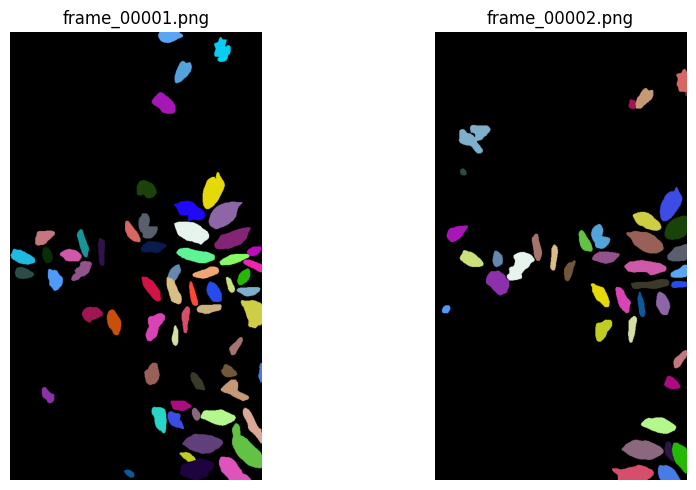

In [94]:
# Plot raw_fns[0] and raw_fns[1] side by side with the same colors
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Load both masks
raw_mask_0 = plt.imread(raw_fns[100])
raw_mask_1 = plt.imread(raw_fns[101])

# Use the same colors for both
raw_mask_img_0 = visualize_mask(raw_mask_0, colors)
raw_mask_img_1 = visualize_mask(raw_mask_1, colors)

axs[0].imshow(raw_mask_img_0)
axs[0].set_title(str(raw_fns[0].name))
axs[0].axis('off')

axs[1].imshow(raw_mask_img_1)
axs[1].set_title(str(raw_fns[1].name))
axs[1].axis('off')

plt.tight_layout()
plt.show()

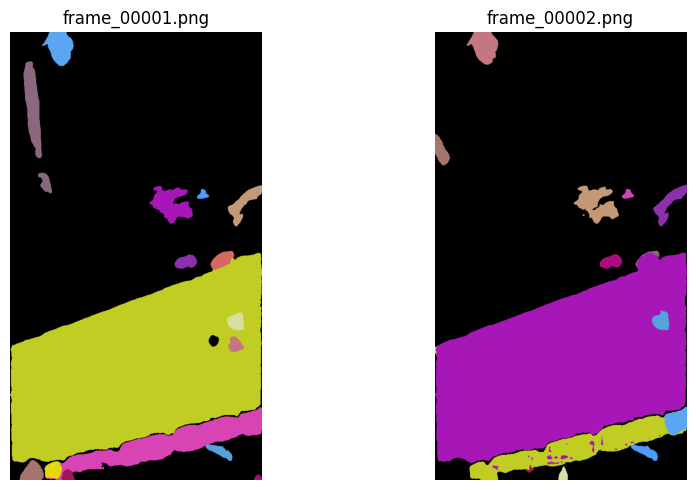

In [91]:
# Plot associated_fns[0] and associated_fns[1] side by side with the same colors
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Load both masks
associated_mask_0 = plt.imread(associated_fns[0])
associated_mask_1 = plt.imread(associated_fns[1])

# Use the same colors for both
associated_mask_img_0 = visualize_mask(associated_mask_0, colors)
associated_mask_img_1 = visualize_mask(associated_mask_1, colors)

axs[0].imshow(associated_mask_img_0)
axs[0].set_title(str(associated_fns[0].name))
axs[0].axis('off')

axs[1].imshow(associated_mask_img_1)
axs[1].set_title(str(associated_fns[1].name))
axs[1].axis('off')

plt.tight_layout()
plt.show()

### Associate masks

In [ ]:
grouping_classifier.create_masks()

In [ ]:
grouping_classifier.associate()

### Try pytorch lightning datamodule

Train identity embeddings to lift objects from 2d to 3d

In [ ]:
grouping_classifier.load_pipeline()

In [ ]:
import wandb
from pytorch_lightning.loggers import WandbLogger

logger = WandbLogger(
    project="collab-splats", 
    name=f"grouping_{species}",
    log_model=False
)

# grouping_classifier.config.identity_dim = 16

# # Use simulated data (10 total mask types)
# grouping_classifier.total_masks = 10

grouping_classifier.setup()

In [ ]:
grouping_classifier.lift_segmentation(logger=logger)

### Random junk

In [ ]:
from collab_splats.utils.grouping import GroupingDataModule 

datamodule = GroupingDataModule(
    datamanager=grouping_classifier.pipeline.datamanager,
    mask_dir=grouping_classifier.associated_mask_dir,
    device="cuda",
    train_num_workers=0,
    val_num_workers=0,
    use_simulated=True
)

In [ ]:
plt.imshow(x[1]['segmentation'].detach().cpu().numpy())

In [ ]:
torch.unique(x[1]['segmentation'])

In [ ]:
grouping_classifier.training_step(x, 0)

In [ ]:
outs = grouping_classifier(x[0])

In [ ]:
plt.imshow(outs['identities'][..., :3].detach().cpu().numpy())

In [ ]:
outs['identities']

In [ ]:
import numpy as np

grouping_classifier.eval()
logits = grouping_classifier(camera)

labels = logits.argmax(0).detach().cpu().numpy()
unique_labels = np.unique(labels)

print (unique_labels)

plt.imshow(labels)

plt.imshow(data['segmentation'])

In [ ]:
from torch.nn import CrossEntropyLoss

identities = identities.unsqueeze(0)
segmentation = data['segmentation'].unsqueeze(0).to(grouping_classifier.model.device)

CrossEntropyLoss(reduction="none")(identities, segmentation)

# grouping_classifier.loss_fn(identities, data['segmentation'])

### Try to map onto the mesh?

In [ ]:
import pickle
import open3d as o3d
from collab_splats.utils.mesh import features2vertex


mesh_dir = grouping_classifier.output_dir.parent / 'mesh'

mesh_path = mesh_dir / 'mesh.ply'
transforms_path = mesh_dir / 'transforms.pkl'

with open(transforms_path, 'rb') as f:
    transforms = pickle.load(f)

mesh = o3d.io.read_triangle_mesh(mesh_path)


In [ ]:
# Transform the means to the mesh
means = grouping_classifier.model.means.clone()
means = means @ transforms["mesh_transform"][:3, :3].T + transforms["mesh_transform"][:3, 3]

# Get the classes for each point
classes = grouping_classifier.per_gaussian_forward(grouping_classifier.identities)
classes = classes.argmax(-1).unsqueeze(-1)

Map to the mesh

In [ ]:
mesh_classes = features2vertex(
    mesh_vertices=mesh.vertices,
    points=means,
    features=classes,
    categorical=True
)

In [ ]:
import torch

# Create RGB colors for each unique class
unique_classes = torch.unique(mesh_classes)
n_classes = len(unique_classes)

# Generate distinct colors using HSV colorspace for better visual separation
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab10')  # or 'viridis', 'plasma', etc.

# Create color mapping
class_to_rgb = {}
for i, class_id in enumerate(unique_classes):
    color = cmap(i / max(1, n_classes - 1))  # Normalize to [0,1]
    class_to_rgb[class_id.item()] = torch.tensor(color[:3], dtype=torch.float32)  # RGB only

# Map classes to RGB colors
rgb_colors = torch.zeros(mesh_classes.shape[0], 3, dtype=torch.float32)
for i, class_id in enumerate(mesh_classes.squeeze()):
    rgb_colors[i] = class_to_rgb[class_id.item()]

rgb_colors

In [ ]:
import pyvista as pv

mesh = pv.read(mesh_path.as_posix())

print(mesh.n_points)
print(mesh.n_cells)
print(mesh.bounds)

image = mesh.plot(
    scalars=rgb_colors, 
    rgb=True,
    screenshot=True
)

plt.imshow(image)